# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=1,
          tokenizer_version=1,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=7,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          print_freq=6,
          random_seed=20,
          scheduler='cosine',
          stride=192,
          train=True,
          train_folds=[0, 1, 2, 3, 4, 5, 6, 7],
          weight_decay=0.01)


In [5]:
seed_everything()

### Setting Up WandB

In [6]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
WANDB_NAME = f"{config.model}-{config.max_length}"

In [7]:
wandb.login(key=os.environ.get('WANDB_NOTEBOOK_NAME'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin


## 📖 Definitions

### 🌎 Global Variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [ ]:
# class_weights = torch.tensor([1.25, 1.0, 1.0, 1.0, 1.0, 1.5]).to(device)
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

### 🛠️ Functions

In [9]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(train_loader, device)

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        wandb.log(
            {
                f"eval/eval_loss_f{fold}": avg_val_loss,
                f"eval/qwk_score_f{fold}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                Paths.MODEL_OUTPUT_PATH
                + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    valid_fold["pred_score"] = predictions

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [10]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [11]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Validation: 100%|██████████| 96/96 [00:15<00:00,  6.10valid_batch/s]


Epoch 1 - avg_train_loss: 1.2751  avg_val_loss: 1.1227  time: 162s
Epoch 1 - Score: 0.7397
Epoch 1 - Save Best Score: 0.7397 Model


Validation: 100%|██████████| 96/96 [00:15<00:00,  6.17valid_batch/s]


Epoch 2 - avg_train_loss: 0.9937  avg_val_loss: 1.0935  time: 160s
Epoch 2 - Score: 0.7391
========== Fold: 0 result ==========
Score: 0.7397
========== Fold: 1 training ==========


Validation: 100%|██████████| 95/95 [00:15<00:00,  6.20valid_batch/s]


Epoch 1 - avg_train_loss: 1.2696  avg_val_loss: 1.0598  time: 159s
Epoch 1 - Score: 0.7562
Epoch 1 - Save Best Score: 0.7562 Model


Validation: 100%|██████████| 95/95 [00:15<00:00,  6.19valid_batch/s]


Epoch 2 - avg_train_loss: 0.9804  avg_val_loss: 1.0775  time: 158s
Epoch 2 - Score: 0.7479
========== Fold: 1 result ==========
Score: 0.7562
========== Fold: 2 training ==========


Validation: 100%|██████████| 110/110 [00:17<00:00,  6.13valid_batch/s]


Epoch 1 - avg_train_loss: 1.2907  avg_val_loss: 1.0162  time: 157s
Epoch 1 - Score: 0.7110
Epoch 1 - Save Best Score: 0.7110 Model


Validation: 100%|██████████| 110/110 [00:17<00:00,  6.18valid_batch/s]


Epoch 2 - avg_train_loss: 1.0096  avg_val_loss: 0.9614  time: 158s
Epoch 2 - Score: 0.7197
Epoch 2 - Save Best Score: 0.7197 Model
========== Fold: 2 result ==========
Score: 0.7197
========== Fold: 3 training ==========


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.23valid_batch/s]


Epoch 1 - avg_train_loss: 1.2751  avg_val_loss: 1.3572  time: 162s
Epoch 1 - Score: 0.5770
Epoch 1 - Save Best Score: 0.5770 Model


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.09valid_batch/s]


Epoch 2 - avg_train_loss: 0.9747  avg_val_loss: 1.4963  time: 163s
Epoch 2 - Score: 0.5685
========== Fold: 3 result ==========
Score: 0.5770
========== Fold: 4 training ==========


Validation: 100%|██████████| 52/52 [00:08<00:00,  6.11valid_batch/s]


Epoch 1 - avg_train_loss: 1.3250  avg_val_loss: 1.1755  time: 168s
Epoch 1 - Score: 0.5076
Epoch 1 - Save Best Score: 0.5076 Model


Validation: 100%|██████████| 52/52 [00:08<00:00,  6.17valid_batch/s]


Epoch 2 - avg_train_loss: 0.9923  avg_val_loss: 1.0627  time: 167s
Epoch 2 - Score: 0.5646
Epoch 2 - Save Best Score: 0.5646 Model
========== Fold: 4 result ==========
Score: 0.5646
========== Fold: 5 training ==========


Validation: 100%|██████████| 62/62 [00:10<00:00,  6.13valid_batch/s]


Epoch 1 - avg_train_loss: 1.2501  avg_val_loss: 1.1043  time: 164s
Epoch 1 - Score: 0.6972
Epoch 1 - Save Best Score: 0.6972 Model


Validation: 100%|██████████| 62/62 [00:10<00:00,  6.00valid_batch/s]


Epoch 2 - avg_train_loss: 0.9552  avg_val_loss: 1.1817  time: 166s
Epoch 2 - Score: 0.6286
========== Fold: 5 result ==========
Score: 0.6972
========== Fold: 6 training ==========


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.06valid_batch/s]


Epoch 1 - avg_train_loss: 1.2509  avg_val_loss: 1.2909  time: 166s
Epoch 1 - Score: 0.7098
Epoch 1 - Save Best Score: 0.7098 Model


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.07valid_batch/s]


Epoch 2 - avg_train_loss: 0.9610  avg_val_loss: 1.0979  time: 164s
Epoch 2 - Score: 0.7425
Epoch 2 - Save Best Score: 0.7425 Model
========== Fold: 6 result ==========
Score: 0.7425
========== CV ==========
Score: 0.7195


In [12]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [13]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

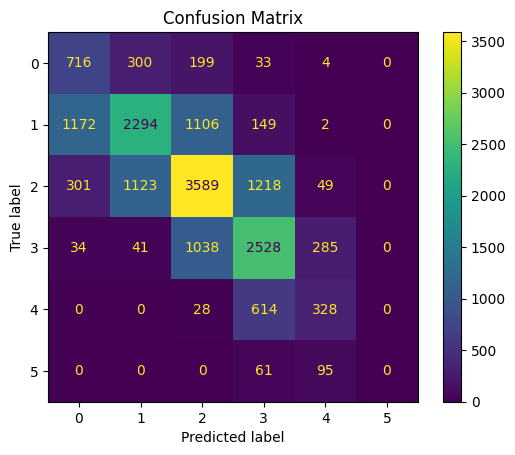

In [14]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [15]:
wandb.finish()

CV/qwk_score,▁
Fold 0/Accuracy,▇▃▁▃▆█
Fold 0/Error Rate,▂▆█▆▃▁
Fold 0/F1 Score,▂▇█▆▁
Fold 0/Precision,▄█▇▅▁
Fold 0/Recall,▄▇█▇▄▁
Fold 0/Sensitivity,▄▇█▇▄▁
Fold 0/Specificity,▇▅▁▄▇█
Fold 1/Accuracy,▄▁▁▃▇█
Fold 1/Error Rate,▅██▆▂▁
Fold 1/F1 Score,▄▃█▆▁
